#Airbus Ship Detection

Following the preprocessing file , we are going to upload from Google Drive, a compressed folder which includes 4070 Images (2035 images with ships and 2035 images without ships) and a csv file which includes images related annotations. A convolutional neural network will be trained to classify images with and without ships and then will be tested. This classifier will be apply furtherly to images before segmentation neural networks to try to improve segmentation results. 

Even with a reduced number of images, we have got  RAM "Out of memory errors" . To fix that problem, original  images shape will be reduced from 768pixels x 768pixels to 256pixels x 256pixels.

In [0]:
# librairies installation for importing files from google drive and if necessary for unzipping them
!pip install -U -q PyDrive
!apt-get install unrar

In [0]:
#importing basic librairies
import os,sys,random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from skimage.io import imread,imsave
from PIL import Image
from sklearn.metrics import confusion_matrix
import statistics

In [0]:
#importing keras librairies
import keras
from keras.layers import *
from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate,Conv2D,Input,MaxPooling2D,UpSampling2D,Dropout,Activation                   
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [0]:
#importing librairies for  interaction between Google Collaboratory and  Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#images uploading and unzipping
!rm -rf airbus_ship_images_4070
!mkdir airbus_ship_images_4070
downloaded = drive.CreateFile({'id':'1aoZHD_yXnxtuadLeCjso076_ndyAR4Ot'})
downloaded.GetContentFile('airbus_ship_images_4070.rar')
!unrar e -y *.rar /content/airbus_ship_images_4070/ -idq
!rm *.rar

In [0]:
#annotations file uploading
downloaded = drive.CreateFile({'id':'13GxdyJ76-LYTFZMOLZDgjZKCHql3qPRu'})
downloaded.GetContentFile('new_ships_dataset.csv')

In [0]:
#reading annotations ('ImageId' and 'ship'features are relevant features for classification)
sample_class= pd.read_csv('new_ships_dataset.csv')
sample_class.head()

,ImageId,EncodedPixels,ship
0,0e3277345.jpg,NaN,0
1,3d315bf5c.jpg,NaN,0
2,ab4c61871.jpg,31563 1 32330 3 33097 5 33864 7 34631 9 35398 ...,1
3,f624897e4.jpg,NaN,0
4,581e286b4.jpg,185650 2 186414 6 187179 10 187944 13 188708 1...,1


In [0]:
# data splitting -> training 80% and validation 20% 
# class proportion is maintained with stratify parameter
X=sample_class
y=sample_class['ship']
img_train, img_val, class_train,class_val = train_test_split(X, y,stratify=y,test_size = 0.2,random_state=50)

In [0]:
print("% of images without ships in training set is {0}, % of images without ships in validation set is {1}".format(class_train.value_counts()[0]/len(class_train)*100,class_val.value_counts()[0]/len(class_val)*100))
print("% of images with    ships in training set is {0}, % of images with    ships in validation set is {1}".format(class_train.value_counts()[1]/len(class_train)*100,class_val.value_counts()[1]/len(class_val)*100))

% of images without ships in training set is 50.0, % of images without ships in validation set is 50.0
% of images with    ships in training set is 50.0, % of images with    ships in validation set is 50.0


In [0]:
# generation of batches of images and classes('ship' feature)
# df dataframe where features are read
# new size is the size of the input images used to train the convolutional neural network
# batch size is the number of training images in one forward/backward pass through the neural network.
def image_batch_generator(df,new_size,batch_size=64):
  
    batch_img, batch_class = [], []
    
    list_batches=list(df['ImageId'])
  
    while True:
    
        np.random.shuffle(list_batches)
      # shuffle is used in case all training images cannot be trained due to RAM out of memory error
      # using random batches at the end of each epoch a higher number of images are used to train neural network with a better result 
    
        for img_name in list_batches:
            #image resizing to new_size
            img_path = os.path.join('airbus_ship_images_4070/',img_name)
            img = Image.open(img_path)
            img_resized = img.resize((new_size,new_size),Image.ANTIALIAS)
            
            np_image = np.array(img_resized)
      
            class_image=df[df['ImageId']==img_name]['ship'].iloc[0]
      
            np_class = np.array(class_image)
            #batch list of images
            batch_img.append(np_image)
            #batch list of classes
            batch_class.append(np_class)
      
            if len(batch_img)>=batch_size:
                # transformation list to array(images and classes) and normalisation of images
                # dimension expansion for Keras input matching
                yield np.stack(batch_img, axis=0)/255., np.expand_dims(np.stack(batch_class, axis=0),axis=1)
                batch_img, batch_class=[], []
        # total number of images is not a multiple of batch_size-> residual batch_size lower than all other batches size
        if len(batch_img) !=0:
            #transformation list to array(images and classes) and normalisation of images
            # dimension expansion for Keras input matching
            yield np.stack(batch_img, axis=0)/255., np.expand_dims(np.stack(batch_class, axis=0),axis=1)
            batch_img, batch_class=[], []

In [0]:
#convolutional neural network
def Classifier(height,width,n_channels):
    #height->image height
    #width ->image width 
    #n_channels: 1 for grey images and 3 for color images
    inputs = (height, width, n_channels)
    
    classifier=Sequential()
    #input convolutional layer 32 filters 3x3, input->(height,width,n_channels)
    classifier.add(Conv2D(32,kernel_size=(3,3),input_shape=inputs))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2)) # selection of most significant pixel in a 2x2 filter
    #hidden convolutional layer nº1 48 filters 3x3, input->(height/2,width/2,32)
    classifier.add(Conv2D(48,kernel_size=(3,3)))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2))
    #hidden convolutional layer nº2 64 filters 3x3, input->(height/4,width/4,48)
    classifier.add(Conv2D(64,kernel_size=(3,3)))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2))
    #hidden convolutional layer nº3 96 filters 3x3, input->(height/8,width/8,64)
    classifier.add(Conv2D(96,kernel_size=(3,3)))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2))
    #hidden convolutional layer nº4 128 filters 3x3, input->(height/16,width/16,96)
    classifier.add(Conv2D(128,kernel_size=(3,3)))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2))
    #output array of convolutional layers is flattened into a vector of 1 dimension, input -> (height/32,width/32,128) 
    classifier.add(Flatten())
    #hidden dense layer 128 neurons, input -> (height/32*width/32*128,)
    classifier.add(Dense(units=128)) 
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(Dropout(0.3))#random deactivation of 30% of neurons to avoid overfitting
    #output dense layer 1 neuron, input-> (128,)
    classifier.add(Dense(units=1))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(Activation('sigmoid'))
    
    return classifier

In [0]:
#classifier model creation with 256x256 resized coloured images
classifier=Classifier(256,256,3)

In [0]:
#model compilation with a cross_entropy loss function and accuracy metrics
classifier.compile(optimizer=Adam(1e-3, decay=2e-6),loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
#as a small amount of images is used to train neural network, at each batch,several operations are randomly performed on images
#these operations are rotation,shifting,zooming and flipping and they augment artificially the number of different images
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

Img_datagen = ImageDataGenerator(**data_gen_args)
Class_datagen = ImageDataGenerator()

def augmentation_generator(img_batch_gen,img_datagen,class_datagen):
  
  for in_img, in_class in img_batch_gen:
    seed = np.random.choice(range(1000))
    #images are denormalize to apply augmentation operations
    aug_img = img_datagen.flow(255*in_img,in_class,batch_size = in_img.shape[0],seed=seed,shuffle=True)
   
    x, y = next(aug_img)
    #images are normalized again to be applied to neural network
    yield x/255.0, y

In [0]:
#parameters of model fit function
#train generator has the following shape (48,256,256,3) 48 coloured images 256pixels x 256pixels 
train_generator=augmentation_generator(image_batch_generator(img_train, 256,batch_size=48),Img_datagen,Class_datagen)
val_generator=next(image_batch_generator(img_val,256,batch_size=len(img_val)))
steps_train=len(img_train)//48

In [0]:
#callback functions: 
#saving best weights, save metrics and losses in file classification_weights.best.hdf5
#learning rate is reduce at 90% if result accuracy is not improved in 3 epochs
#training is stopped if result accuracy is not improved after 40 epochs
weight_path="{}_weights.best.hdf5".format('classification')

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.9, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_acc", 
                      mode="max", 
                      patience=40) # probably needs to be more patient, but kaggle time is limited

callbacks_classification = [checkpoint, early, reduceLROnPlat]

In [0]:
#training the model
loss_classifier=classifier.fit_generator(train_generator, validation_data=val_generator, steps_per_epoch=steps_train, epochs=100,workers=1,callbacks=callbacks_classification)

Epoch 1/100
67/67 [==============================] - 112s 2s/step - loss: 0.4845 - acc: 0.7914 - val_loss: 0.3956 - val_acc: 0.8354

Epoch 00001: val_acc improved from -inf to 0.83538, saving model to classification_weights.best.hdf5
Epoch 2/100
67/67 [==============================] - 103s 2s/step - loss: 0.4453 - acc: 0.8259 - val_loss: 0.4170 - val_acc: 0.8231

Epoch 00002: val_acc did not improve from 0.83538
Epoch 3/100
67/67 [==============================] - 104s 2s/step - loss: 0.4221 - acc: 0.8455 - val_loss: 0.4176 - val_acc: 0.8342

Epoch 00003: val_acc did not improve from 0.83538
Epoch 4/100
67/67 [==============================] - 108s 2s/step - loss: 0.4082 - acc: 0.8548 - val_loss: 0.4102 - val_acc: 0.8378

Epoch 00004: val_acc improved from 0.83538 to 0.83784, saving model to classification_weights.best.hdf5
Epoch 5/100
67/67 [==============================] - 105s 2s/step - loss: 0.3981 - acc: 0.8641 - val_loss: 0.5168 - val_acc: 0.7101

Epoch 00005: val_acc did not i

We obtain a 93.61% best value accuracy

In [0]:
#best weight values are downloaded to PC
files.download('classification_weights.best.hdf5')

In [0]:
#previous best weights are loaded into the classifier model
classifier.load_weights('classification_weights.best.hdf5')

In [0]:
#generation of output images batches to make predictions
val_batch=image_batch_generator(img_val,256,len(img_val))
val_batch_image,val_batch_class=next(val_batch)

In [0]:
#prediction of validation set images
#as classifier outputs are probabilities threshold=0.5 is considered to generate 1s and 0s.
y_pred=classifier.predict(val_batch_image)
y_pred=np.where(y_pred >= 0.5, 1,0)

In [0]:
cm=confusion_matrix(y_pred,val_batch_class)

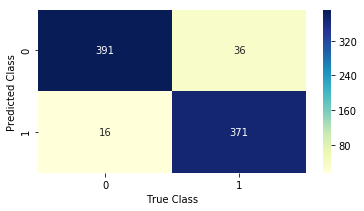

In [0]:
#confusion matrix plot
labels=[0,1]
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

We can check with this confusion matrix the best accuracy obtained during training time. Accuracy is (True positive->371) + (True negative->391) divided by ((True positive->371) + (True negative ->391)+(False positive->16)+(False negative->36))

In [0]:
print("Accuracy -> {:.2f}%".format((371+391)/(371+391+16+36)*100))

Accuracy -> 93.61%


All classification model weights have been saved and are ready to be loaded to preclassify images before segmentation. If improvement is achieved, classification and segmentation will be used sequentially.